In [2]:
# Importing necessary libraries for handling the data
import pandas as pd

# Loading the datasets provided
suicidewatch_posts = pd.read_csv('SuicideWatch_posts.csv')
depression_posts = pd.read_csv('depression_posts.csv')
depression_comments = pd.read_csv('depression_comments.csv')
suicidewatch_comments = pd.read_csv('SuicideWatch_comments.csv')


# Combining all posts datasets into a single DataFrame 'df_posts'
df_posts = pd.concat([suicidewatch_posts,depression_posts], ignore_index=True)

df_posts = df_posts.drop(columns=['Flair'])


# Combining all comments datasets into a single DataFrame 'df_comments'
df_comments = pd.concat([suicidewatch_comments,depression_comments], ignore_index=True)

# Displaying the structure of the combined datasets to confirm the merge
df_posts_shape = df_posts.shape
df_comments_shape = df_comments.shape

df_posts_head = df_posts.head()
df_comments_head = df_comments.head()

df_posts_shape, df_comments_shape, df_posts_head, df_comments_head


((10000, 8),
 (23042, 7),
                    User                                         Post Title  \
 0         gktqkbcnbr_jj           I just don’t care and want to end things   
 1        Sad_Cancel_705         I’ve decided to kill myself in 30 minutes    
 2           Thatmaa4986                      Suicidal at 34 weeks pregnant   
 3  Expensive_Flounder28  I finally figured out which way I'm going to k...   
 4  MalsAdaptiveDreaming  Thinking of jumping off a bridge above water. ...   
 
                                              Content  Score  Comments Count  \
 0                                                NaN      1               0   
 1  I 19m just wants someone to talk to before I d...      2               0   
 2  (28F) I am 34 weeks pregnant and struglling wi...      4               1   
 3  I'm going to wait until a very cold winter nig...      2               0   
 4  I wonder what the lethality is for 20-25 feet ...      1               0   
 
    Upvote Ratio

In [3]:
# Import required libraries
import re

from nltk.corpus import stopwords
import nltk
import spacy
# Download stopwords if not already available
#nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

# Define a comprehensive data cleaning function
def preprocess_text(text, remove_stopwords=True, convert_emojis=False):
    # Convert non-string entries to an empty string
    if not isinstance(text, str):
        text = ""
    # Remove URLs, emails, newline symbols, and HTML tags
    text = re.sub(r'http\S+|www.\S+|\b\w+@\w+\.\w+\b|<.*?>', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)
    # Optionally handle emojis
    if convert_emojis:
        text = re.sub(r'[\U0001F600-\U0001F64F]', '[EMOJI]', text)  # Converts emojis to [EMOJI] label
    else:
        text = re.sub(r'[\U0001F600-\U0001F64F]', '', text)  # Removes emojis
    # Convert to lowercase
    text = text.lower()
    # Process text with SpaCy and optionally remove stopwords
    doc = nlp(text)
    if remove_stopwords:
        return ' '.join([token.lemma_ for token in doc if token.text not in stop_words])
    else:
        return ' '.join([token.lemma_ for token in doc])

# Apply this cleaning function to text columns in your datasets
df_posts['Content'] = df_posts['Content'].apply(lambda x: preprocess_text(x, remove_stopwords=True, convert_emojis=False))
df_comments['Comment Body'] = df_comments['Comment Body'].apply(lambda x: preprocess_text(x, remove_stopwords=True, convert_emojis=False))


In [4]:
# Importing necessary libraries for tokenization
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy

# Downloading NLTK resources if not already available
#nltk.download('punkt')
#nltk.download('punkt_tab')
# Loading SpaCy model
nlp = spacy.load("en_core_web_sm")

# Define a function to perform tokenization
def tokenize_text(text, level='word', method='spacy'):
    """
    Tokenizes text based on specified level and method.

    Parameters:
    - text (str): Input text to be tokenized.
    - level (str): 'word' for word-level tokenization or 'sentence' for sentence-level tokenization.
    - method (str): 'spacy' for SpaCy tokenization, 'nltk' for NLTK tokenization.

    Returns:
    - list: List of tokens at the specified level.
    """
    if not isinstance(text, str):
        return []  # Return empty list if text is not a valid string
    
    if method == 'spacy':
        doc = nlp(text)
        if level == 'word':
            tokens = [token.text for token in doc]
        elif level == 'sentence':
            tokens = [sent.text for sent in doc.sents]
    elif method == 'nltk':
        if level == 'word':
            tokens = word_tokenize(text)
        elif level == 'sentence':
            tokens = sent_tokenize(text)
    
    return tokens

# Applying tokenization on 'Content' in posts and 'Comment Body' in comments

# For posts - SpaCy word-level and sentence-level tokenization
df_posts['SpaCy_Word_Tokens'] = df_posts['Content'].apply(lambda x: tokenize_text(x, level='word', method='spacy'))
df_posts['SpaCy_Sentence_Tokens'] = df_posts['Content'].apply(lambda x: tokenize_text(x, level='sentence', method='spacy'))

# For comments - NLTK word-level and sentence-level tokenization
df_comments['NLTK_Word_Tokens'] = df_comments['Comment Body'].apply(lambda x: tokenize_text(x, level='word', method='nltk'))
df_comments['NLTK_Sentence_Tokens'] = df_comments['Comment Body'].apply(lambda x: tokenize_text(x, level='sentence', method='nltk'))


In [5]:
# Import necessary libraries
import re
import spacy
from nltk.stem import PorterStemmer
from textblob import TextBlob
import contractions  # Import contractions module

# Load SpaCy model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Initialize Porter Stemmer for stemming if needed
stemmer = PorterStemmer()

# Define preprocessing function
def preprocess_text(text, lemmatize=True, use_stemming=False, correct_spelling=False, expand_contractions=True):
    """
    Cleans and preprocesses text by lemmatizing or stemming, with optional spell correction and contraction expansion.
    
    Parameters:
    - text (str): The text to be processed.
    - lemmatize (bool): Whether to apply lemmatization (default is True).
    - use_stemming (bool): Whether to apply stemming (default is False).
    - correct_spelling (bool): Whether to perform spell correction (default is False).
    - expand_contractions (bool): Whether to expand contractions (default is True).
    
    Returns:
    - str: The processed text.
    """
    # Expand contractions if specified
    if expand_contractions:
        text = contractions.fix(text)

    # Convert text to lowercase
    text = text.lower()

    # Spell correction (optional)
    if correct_spelling:
        text = str(TextBlob(text).correct())

    # Tokenize and apply lemmatization or stemming
    processed_tokens = []
    if lemmatize:
        # Lemmatization using SpaCy
        doc = nlp(text)
        processed_tokens = [token.lemma_ for token in doc]
    elif use_stemming:
        # Stemming using NLTK
        words = text.split()
        processed_tokens = [stemmer.stem(word) for word in words]
    else:
        # If neither lemmatization nor stemming, just split the text
        processed_tokens = text.split()

    # Join tokens back into a single string
    return ' '.join(processed_tokens)

# Example usage: Concatenate title and body, apply preprocessing
df_posts['Processed_Text'] = df_posts.apply(
    lambda row: preprocess_text(f"{row['Post Title']} {row['Content']}", 
                                lemmatize=True, 
                                correct_spelling=False, 
                                expand_contractions=True),
    axis=1
)

In [6]:
# # Install necessary libraries
# !pip install transformers

# # Import required libraries
# import pandas as pd
# from transformers import pipeline

# # Load your dataset
# # Ensure 'Processed_Text' column exists in your DataFrame
# # df_posts = pd.read_csv('your_dataset.csv')  # Uncomment and modify this line to load your data

# # Initialize the sentiment analysis pipeline with a pre-trained model
# sentiment_pipeline = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english")

# # Define a function to classify Risk_Level based on sentiment analysis
# def classify_risk_level(text):
#     # Handle empty or missing text entries
#     if not isinstance(text, str) or text.strip() == "":
#         return 'Low'  # Default to 'Low' risk for empty or invalid text
#     # Get the sentiment prediction
#     result = sentiment_pipeline(text[:512])[0]  # Truncate text to 512 tokens if necessary
#     sentiment = result['label']
#     score = result['score']
#     # Map sentiment and score to risk levels
#     if sentiment == 'NEGATIVE':
#         if score > 0.85:
#             return 'High'
#         elif score > 0.6:
#             return 'Moderate'
#         else:
#             return 'Low'
#     else:
#         return 'Low'

# # Apply the function to your DataFrame
# df_posts['Risk_Level'] = df_posts['Processed_Text'].apply(classify_risk_level)

# # Display the updated DataFrame
# print(df_posts[['Processed_Text', 'Risk_Level']].head())


In [7]:
# # Install necessary libraries
# !pip install transformers

# # Import required libraries
# import pandas as pd
# from transformers import pipeline

# # Load your dataset
# # Ensure 'Processed_Text' column exists in your DataFrame
# # df_posts = pd.read_csv('your_dataset.csv')  # Uncomment and modify this line to load your data

# # Initialize the sentiment analysis pipeline with the new model
# sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment")

# # Define a function to classify Risk_Level based on sentiment analysis
# def classify_risk_level(text):
#     # Handle empty or missing text entries
#     if not isinstance(text, str) or text.strip() == "":
#         return 'Low'  # Default to 'Low' risk for empty or invalid text
    
#     # Get the sentiment prediction
#     result = sentiment_pipeline(text[:512])[0]  # Truncate text to 512 tokens if necessary
#     stars = int(result['label'].split()[0])  # Extract the star rating (1 to 5)
    
#     # Map star ratings to risk levels
#     if stars == 1:  # Extremely negative sentiment
#         return 'High'
#     elif stars == 2:  # Negative sentiment
#         return 'Moderate'
#     elif stars == 3:  # Neutral sentiment
#         return 'Moderate'
#     else:  # Positive or extremely positive sentiment (4 or 5 stars)
#         return 'Low'

# # Apply the function to your DataFrame
# df_posts['Risk_Level'] = df_posts['Processed_Text'].apply(classify_risk_level)

# # Display the updated DataFrame
# print(df_posts[['Processed_Text', 'Risk_Level']].head())

# # Visualize the distribution of Risk_Level
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))
# sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm', order=['Low', 'Moderate', 'High'])
# plt.title('Distribution of Risk Levels', fontsize=16)
# plt.xlabel('Risk Level', fontsize=12)
# plt.ylabel('Number of Posts', fontsize=12)
# plt.show()


/var/folders/68/zwqn0ws14_l2cr8xg5jd23gw0000gn/T/ipykernel_80129/363357712.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm', order=['Low', 'Moderate', 'High'])


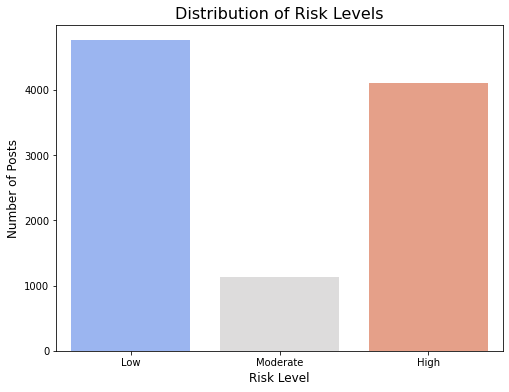

In [8]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER
analyzer = SentimentIntensityAnalyzer()

# Define a function to classify Risk_Level
def classify_risk_level(text):
    sentiment_score = analyzer.polarity_scores(text)['compound']
    if sentiment_score <= -0.85:  # Strongly negative
        return 'High'
    elif -0.6 < sentiment_score <= -0.2:  # Moderately negative
        return 'Moderate'
    else:  # Neutral or positive
        return 'Low'

# Apply to the dataset
df_posts['Risk_Level'] = df_posts['Processed_Text'].apply(classify_risk_level)

# Visualize the distribution of Risk_Level
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.countplot(data=df_posts, x='Risk_Level', palette='coolwarm', order=['Low', 'Moderate', 'High'])
plt.title('Distribution of Risk Levels', fontsize=16)
plt.xlabel('Risk Level', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
plt.show()


In [9]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Download required NLTK data files
nltk.download('punkt')

# Function to compute the statistical features
def compute_text_statistics(title, body):
    # Title statistics
    title_words = word_tokenize(title)
    title_tokens = len(title_words)
    title_chars = len(title)
    title_word_count = len([word for word in title_words if word.isalpha()])

    # Body statistics
    body_words = word_tokenize(body)
    body_tokens = len(body_words)
    body_chars = len(body)
    body_word_count = len([word for word in body_words if word.isalpha()])
    body_sentences = len(sent_tokenize(body))
    body_paragraphs = len(body.split('\n'))  # Assuming paragraphs are separated by new lines

    return {
        'Title_Word_Count': title_word_count,
        'Title_Token_Count': title_tokens,
        'Title_Char_Count': title_chars,
        'Body_Word_Count': body_word_count,
        'Body_Token_Count': body_tokens,
        'Body_Char_Count': body_chars,
        'Body_Sentence_Count': body_sentences,
        'Body_Paragraph_Count': body_paragraphs
    }

# Apply the function to each post and store the results in new columns
df_posts[['Title_Word_Count', 'Title_Token_Count', 'Title_Char_Count',
          'Body_Word_Count', 'Body_Token_Count', 'Body_Char_Count',
          'Body_Sentence_Count', 'Body_Paragraph_Count']] = df_posts.apply(
    lambda row: pd.Series(compute_text_statistics(row['Post Title'], row['Processed_Text'])), axis=1)
          
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Use CountVectorizer to create a term-document matrix
count_vectorizer = CountVectorizer(max_df=0.9, min_df=10, stop_words='english')
dtm = count_vectorizer.fit_transform(df_posts['Processed_Text'])

# Step 2: Apply LDA to extract topics
num_topics = 10  # You can choose the number of topics based on your analysis
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda.fit_transform(dtm)  # This will give us the topic probabilities for each post

# lda_topics will be a matrix of shape (n_posts, n_topics)
# Each row corresponds to a post, and each column represents the probability of the post belonging to a particular topic

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer

# Step 1: Generate TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, min_df=10, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df_posts['Processed_Text'])

# Step 2: Train Word2Vec model or load a pre-trained model
word2vec_model = Word2Vec(sentences=[text.split() for text in df_posts['Processed_Text']], vector_size=100, window=5, min_count=1, workers=4)

# Function to get Word2Vec embeddings for a document (average word vectors)
def get_word2vec_embedding(text, model):
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    return np.mean(word_vectors, axis=0) if word_vectors else np.zeros(model.vector_size)

# Apply Word2Vec embeddings
word2vec_embeddings = df_posts['Processed_Text'].apply(lambda x: get_word2vec_embedding(x, word2vec_model))

# Step 3: Combine TF-IDF and Word2Vec features
# Convert word2vec embeddings to an array
word2vec_matrix = np.array(word2vec_embeddings.tolist())

# Step 3: Combine TF-IDF, Word2Vec, and Statistical features

# Extract statistical features into a numpy array
statistical_features = df_posts[['Title_Word_Count', 'Title_Token_Count', 'Title_Char_Count',
                                 'Body_Word_Count', 'Body_Token_Count', 'Body_Char_Count',
                                 'Body_Sentence_Count', 'Body_Paragraph_Count']].values

# The topic features (lda_topics) are the probability distributions over the topics for each post
#topic_features = lda_model

# Step 5: N-gram features (specifically trigrams)
# ngram_vectorizer = CountVectorizer(ngram_range=(3, 3), stop_words='english')  # We are using only trigrams here
# ngram_matrix = ngram_vectorizer.fit_transform(df_posts['Processed_Text'])


# Now concatenate TF-IDF, Word2Vec, and statistical features
# Combine all features: TF-IDF, Word2Vec, Statistical, and Topic features,ngram features
combined_features = np.hstack([tfidf_matrix.toarray(), word2vec_matrix, statistical_features,lda_topics])

# You can now use the combined_features for further machine learning tasks
from liwc_categories import liwc_categories  # Assuming you have a file/module with LIWC categories

from nltk.tokenize import word_tokenize

def calculate_liwc_features(text, categories):
    """
    Calculate LIWC-like features for a single text.
    
    Parameters:
    - text (str): The text to process.
    - categories (dict): Dictionary of LIWC categories and their associated words.
    
    Returns:
    - dict: A dictionary with counts for each LIWC category.
    """
    liwc_counts = {category: 0 for category in categories.keys()}
    words = word_tokenize(text.lower())  # Tokenize and lowercase the text

    # Count occurrences for each LIWC category
    for category, words_list in categories.items():
        liwc_counts[category] = sum(1 for word in words if word in words_list)

    # Normalize counts by the number of words in the text
    total_words = len(words)
    if total_words > 0:
        liwc_counts = {key: value / total_words for key, value in liwc_counts.items()}
    else:
        liwc_counts = {key: 0 for key in liwc_counts.keys()}

    return liwc_counts

# Apply LIWC feature calculation to each post
liwc_features = df_posts['Processed_Text'].apply(lambda x: calculate_liwc_features(x, liwc_categories))

# Convert the list of LIWC features (dicts) into a DataFrame
liwc_features_df = pd.DataFrame(liwc_features.tolist())

# Concatenate the LIWC features to the original posts DataFrame
df_posts = pd.concat([df_posts, liwc_features_df], axis=1)

# Apply LIWC feature calculation to each post
liwc_features = df_posts['Processed_Text'].apply(lambda x: calculate_liwc_features(x, liwc_categories))

# Convert the list of LIWC features (dicts) into a DataFrame
liwc_features_df = pd.DataFrame(liwc_features.tolist())

# Concatenate the LIWC features to the original posts DataFrame
df_posts = pd.concat([df_posts, liwc_features_df], axis=1)

# Extract LIWC features into a numpy array
liwc_features_array = df_posts[liwc_features_df.columns].values

# Combine LIWC features with other feature matrices (e.g., TF-IDF, Word2Vec, etc.)
combined_features = np.hstack([tfidf_matrix.toarray(), word2vec_matrix, statistical_features, lda_topics, liwc_features_array])


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rakibabdullah/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE

# Step 1: Ensure the target variable 'Risk_Level' does not contain NaN values
df_posts_clean = df_posts.dropna(subset=['Risk_Level'])

# Encode target variable as numerical labels (Low=0, Moderate=1, High=2)
df_posts_clean['Risk_Level'] = df_posts_clean['Risk_Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

# Step 2: Feature extraction
# Combine TF-IDF and Word2Vec matrices (assuming 'combined_features' is already created)
X = combined_features  # Features: concatenated TF-IDF + Word2Vec embeddings
y = df_posts_clean['Risk_Level']  # Target variable


# Step 2: Apply SMOTE
print("Applying SMOTE to balance the dataset...")
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Step 3: Train-Test Split
# Step 1: Split data into train (60%), validation (20%), and test (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X_balanced, y_balanced, test_size=0.4, random_state=42, stratify=y_balanced)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Display the sizes of each dataset
print(f"Train set size: {X_train.shape[0]}")
print(f"Validation set size: {X_valid.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Applying SMOTE to balance the dataset...
Train set size: 8566
Validation set size: 2855
Test set size: 2856


Training KNN...


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accuracy for KNN: 0.9292717086834734
Classification Report for KNN:
              precision    recall  f1-score   support

         Low       0.92      0.91      0.92       952
    Moderate       0.94      0.95      0.95       952
        High       0.93      0.92      0.93       952

    accuracy                           0.93      2856
   macro avg       0.93      0.93      0.93      2856
weighted avg       0.93      0.93      0.93      2856


Training Naive Bayes...
Accuracy for Naive Bayes: 0.896358543417367
Classification Report for Naive Bayes:
              precision    recall  f1-score   support

         Low       0.97      0.83      0.89       952
    Moderate       0.80      0.99      0.89       952
        High       0.95      0.87      0.91       952

    accuracy                           0.90      2856
   macro avg       0.91      0.90      0.90      2856
weighted avg       0.91      0.90      0.90      2856


Training Decision Tree...


[I 2025-01-11 05:07:32,560] A new study created in memory with name: no-name-504a18ac-8d2a-4b85-825a-a0b6644153a9


Accuracy for Decision Tree: 0.9380252100840336
Classification Report for Decision Tree:
              precision    recall  f1-score   support

         Low       0.91      0.92      0.92       952
    Moderate       0.96      0.96      0.96       952
        High       0.94      0.94      0.94       952

    accuracy                           0.94      2856
   macro avg       0.94      0.94      0.94      2856
weighted avg       0.94      0.94      0.94      2856


Training XGBoost...
Tuning hyperparameters for XGBoost...


[I 2025-01-11 05:07:47,782] Trial 0 finished with value: 0.9625218914185639 and parameters: {'n_estimators': 89, 'max_depth': 8, 'learning_rate': 0.17206360544071353, 'subsample': 0.804832338804968, 'colsample_bytree': 0.977301356442567}. Best is trial 0 with value: 0.9625218914185639.
[I 2025-01-11 05:07:54,381] Trial 1 finished with value: 0.9439579684763573 and parameters: {'n_estimators': 71, 'max_depth': 3, 'learning_rate': 0.1489681046998399, 'subsample': 0.7014079075904516, 'colsample_bytree': 0.6784769928612382}. Best is trial 0 with value: 0.9625218914185639.
[I 2025-01-11 05:08:17,808] Trial 2 finished with value: 0.9625218914185639 and parameters: {'n_estimators': 165, 'max_depth': 6, 'learning_rate': 0.07456663615007213, 'subsample': 0.7176093434236683, 'colsample_bytree': 0.7818051193253122}. Best is trial 0 with value: 0.9625218914185639.
[I 2025-01-11 05:08:36,058] Trial 3 finished with value: 0.9614711033274956 and parameters: {'n_estimators': 153, 'max_depth': 5, 'lear

Best parameters for XGBoost: {'n_estimators': 107, 'max_depth': 9, 'learning_rate': 0.2302190055194635, 'subsample': 0.9043076801198614, 'colsample_bytree': 0.739074968276047}


[I 2025-01-11 05:26:11,125] A new study created in memory with name: no-name-382717ea-8f95-4752-814b-9d2dc58601f6


Accuracy for XGBoost: 0.9677871148459384
Classification Report for XGBoost:
              precision    recall  f1-score   support

         Low       0.96      0.96      0.96       952
    Moderate       0.98      0.97      0.98       952
        High       0.97      0.97      0.97       952

    accuracy                           0.97      2856
   macro avg       0.97      0.97      0.97      2856
weighted avg       0.97      0.97      0.97      2856


Training Random Forest...
Tuning hyperparameters for Random Forest...


[I 2025-01-11 05:26:13,723] Trial 0 finished with value: 0.9285464098073555 and parameters: {'n_estimators': 95, 'max_depth': 9, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9285464098073555.
[I 2025-01-11 05:26:16,409] Trial 1 finished with value: 0.9005253940455341 and parameters: {'n_estimators': 154, 'max_depth': 6, 'min_samples_split': 6, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9285464098073555.
[I 2025-01-11 05:26:19,780] Trial 2 finished with value: 0.9330998248686515 and parameters: {'n_estimators': 142, 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9330998248686515.
[I 2025-01-11 05:26:21,897] Trial 3 finished with value: 0.9061295971978984 and parameters: {'n_estimators': 119, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.9330998248686515.
[I 2025-01-11 05:26:23,698] Trial 4 finished with value: 0.8203152364273205 and parameters: {'n_e

Best parameters for Random Forest: {'n_estimators': 197, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 3}
Accuracy for Random Forest: 0.9387254901960784
Classification Report for Random Forest:
              precision    recall  f1-score   support

         Low       0.91      0.95      0.93       952
    Moderate       0.99      0.91      0.95       952
        High       0.92      0.96      0.94       952

    accuracy                           0.94      2856
   macro avg       0.94      0.94      0.94      2856
weighted avg       0.94      0.94      0.94      2856




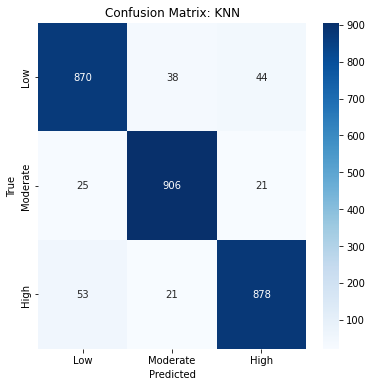

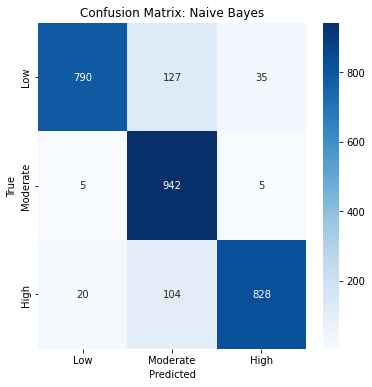

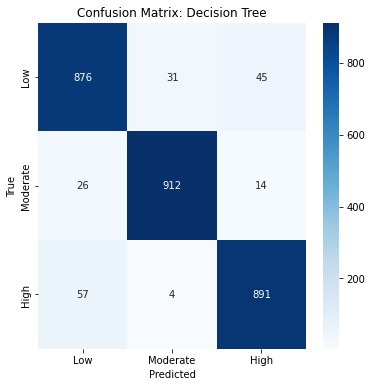

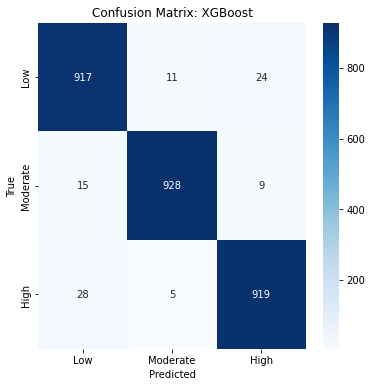

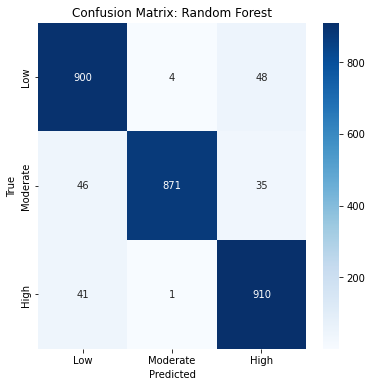

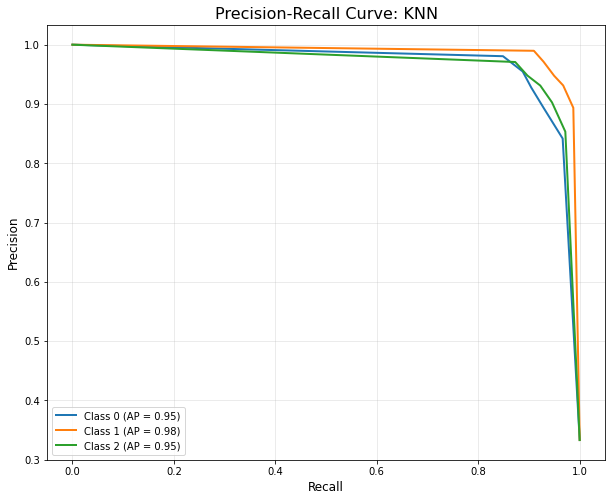

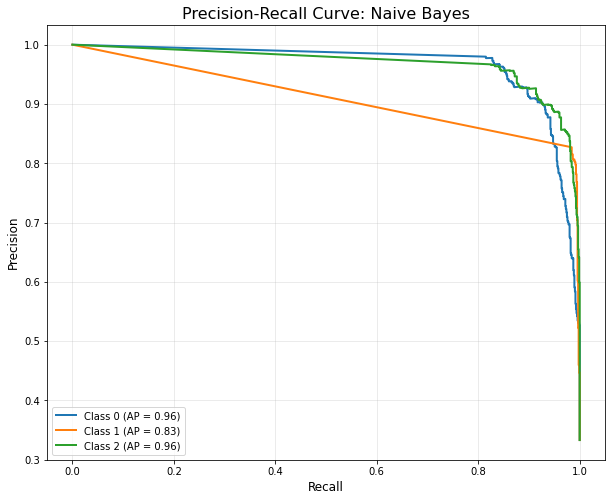

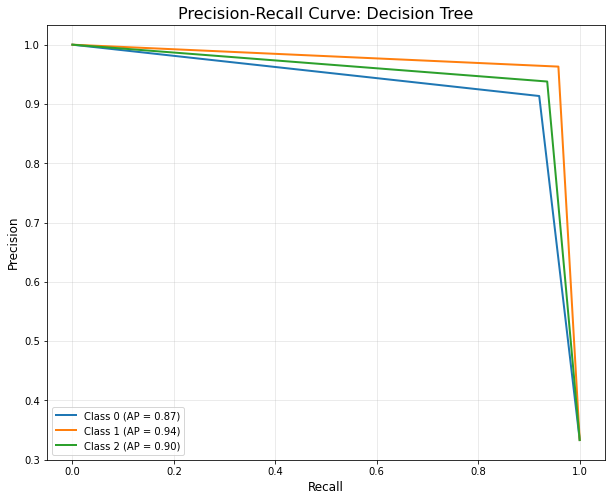

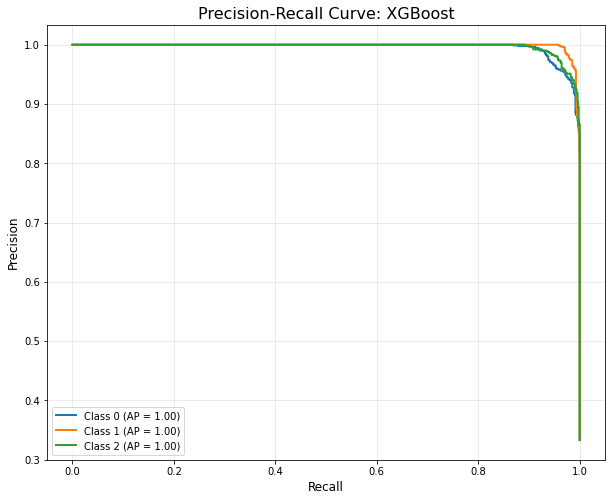

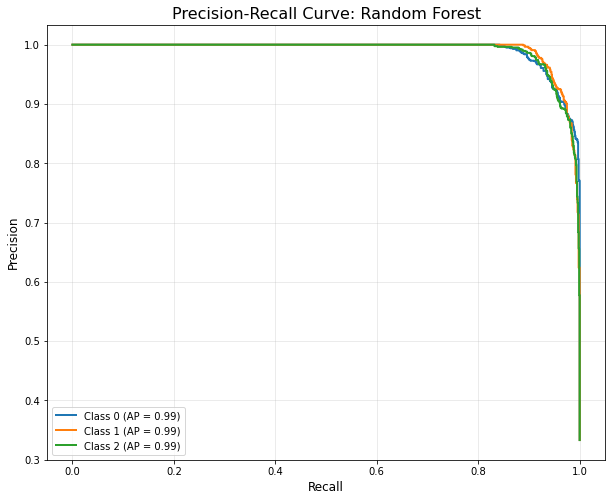

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
import optuna

# Step 1: Define models to train
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}


# Step 3: Hyperparameter tuning using Optuna
def tune_model_with_optuna(model_name, X_train, y_train, X_valid, y_valid):
    def objective(trial):
        if model_name == "Random Forest":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
            }
            model = RandomForestClassifier(random_state=42, **params)
        elif model_name == "XGBoost":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 50, 200),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            }
            model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, **params)
        
        model.fit(X_train, y_train)
        y_pred_valid = model.predict(X_valid)
        return accuracy_score(y_valid, y_pred_valid)

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=30)
    return study.best_params

# Step 4: Train and evaluate each model
results = {}
best_params = {}

# Binarize the target labels for precision-recall curve calculation
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

for name, model in models.items():
    print(f"Training {name}...")
    
    # Hyperparameter tuning for selected models
    if name in ["Random Forest", "XGBoost"]:
        print(f"Tuning hyperparameters for {name}...")
        best_params[name] = tune_model_with_optuna(name, X_train, y_train, X_valid, y_valid)
        print(f"Best parameters for {name}: {best_params[name]}")
        
        # Update model with best parameters
        if name == "Random Forest":
            model = RandomForestClassifier(random_state=42, **best_params[name])
        elif name == "XGBoost":
            model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, **best_params[name])

    # Train the model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

    # Save evaluation metrics
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred, target_names=['Low', 'Moderate', 'High']),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Precision": {},
        "Recall": {},
        "Average Precision": {}
    }

    print(f"Accuracy for {name}: {results[name]['Accuracy']}")
    print(f"Classification Report for {name}:\n{results[name]['Classification Report']}\n")
    
    # Calculate precision-recall curve and average precision for each class
    if y_pred_proba is not None:
        for i in range(n_classes):
            precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_proba[:, i])
            avg_precision = average_precision_score(y_test_binarized[:, i], y_pred_proba[:, i])
            results[name]["Precision"][i] = precision
            results[name]["Recall"][i] = recall
            results[name]["Average Precision"][i] = avg_precision

# Step 5: Visualize results
# Confusion matrices
for name, result in results.items():
    plt.figure(figsize=(6, 6))
    sns.heatmap(result["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Precision-Recall Curves
for name, result in results.items():
    if "Precision" in result and result["Precision"]:
        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            plt.plot(result["Recall"][i], result["Precision"][i], lw=2, label=f"Class {i} (AP = {result['Average Precision'][i]:.2f})")
        plt.title(f"Precision-Recall Curve: {name}", fontsize=16)
        plt.xlabel("Recall", fontsize=12)
        plt.ylabel("Precision", fontsize=12)
        plt.legend(loc="lower left", fontsize=10)
        plt.grid(alpha=0.3)
        plt.show()


Training Voting Classifier...
Accuracy for Voting Classifier: 0.9607843137254902
Classification Report for Voting Classifier:
              precision    recall  f1-score   support

         Low       0.95      0.95      0.95       952
    Moderate       0.99      0.97      0.98       952
        High       0.95      0.96      0.95       952

    accuracy                           0.96      2856
   macro avg       0.96      0.96      0.96      2856
weighted avg       0.96      0.96      0.96      2856




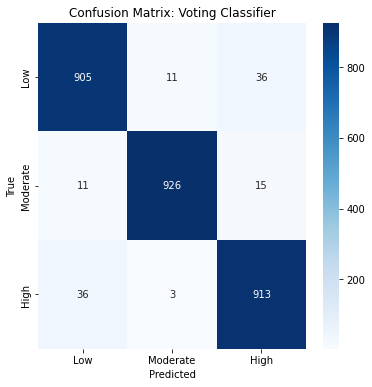

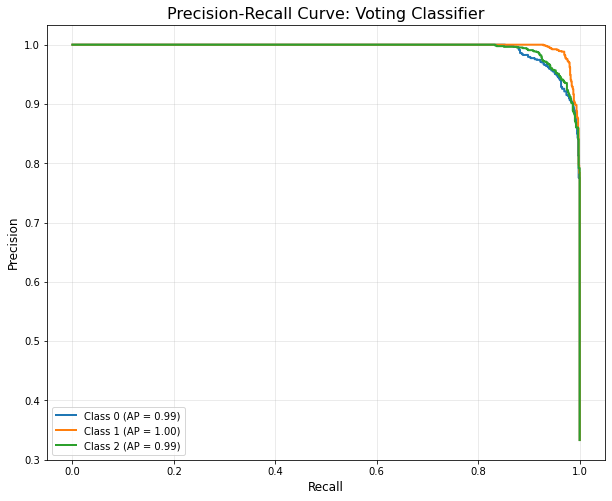

In [12]:
from sklearn.ensemble import VotingClassifier

# Step 1: Define the Voting Classifier
voting_model = VotingClassifier(
    estimators=[
        ('Random Forest', RandomForestClassifier(random_state=42, **best_params['Random Forest'])),
        ('XGBoost', xgb.XGBClassifier(objective='multi:softmax', num_class=3, random_state=42, **best_params['XGBoost'])),
        ('KNN', KNeighborsClassifier(n_neighbors=5))
    ],
    voting='soft'  # Use 'soft' for probability-based voting
)

# Step 2: Train the Voting Classifier
print("Training Voting Classifier...")
voting_model.fit(X_train, y_train)

# Step 3: Evaluate the Voting Classifier
y_pred_voting = voting_model.predict(X_test)
y_pred_voting_proba = voting_model.predict_proba(X_test) if hasattr(voting_model, "predict_proba") else None

# Save evaluation metrics for Voting Classifier
results["Voting Classifier"] = {
    "Accuracy": accuracy_score(y_test, y_pred_voting),
    "Classification Report": classification_report(y_test, y_pred_voting, target_names=['Low', 'Moderate', 'High']),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_voting),
    "Precision": {},
    "Recall": {},
    "Average Precision": {}
}

print(f"Accuracy for Voting Classifier: {results['Voting Classifier']['Accuracy']}")
print(f"Classification Report for Voting Classifier:\n{results['Voting Classifier']['Classification Report']}\n")

# Calculate precision-recall curve and average precision for each class
if y_pred_voting_proba is not None:
    for i in range(n_classes):
        precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_voting_proba[:, i])
        avg_precision = average_precision_score(y_test_binarized[:, i], y_pred_voting_proba[:, i])
        results["Voting Classifier"]["Precision"][i] = precision
        results["Voting Classifier"]["Recall"][i] = recall
        results["Voting Classifier"]["Average Precision"][i] = avg_precision

# Step 4: Visualize the results for the Voting Classifier
# Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(results["Voting Classifier"]["Confusion Matrix"], annot=True, fmt='d', cmap='Blues', xticklabels=['Low', 'Moderate', 'High'], yticklabels=['Low', 'Moderate', 'High'])
plt.title("Confusion Matrix: Voting Classifier")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Precision-Recall Curves for Voting Classifier
if "Precision" in results["Voting Classifier"] and results["Voting Classifier"]["Precision"]:
    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        plt.plot(results["Voting Classifier"]["Recall"][i], results["Voting Classifier"]["Precision"][i], lw=2, label=f"Class {i} (AP = {results['Voting Classifier']['Average Precision'][i]:.2f})")
    plt.title(f"Precision-Recall Curve: Voting Classifier", fontsize=16)
    plt.xlabel("Recall", fontsize=12)
    plt.ylabel("Precision", fontsize=12)
    plt.legend(loc="lower left", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()


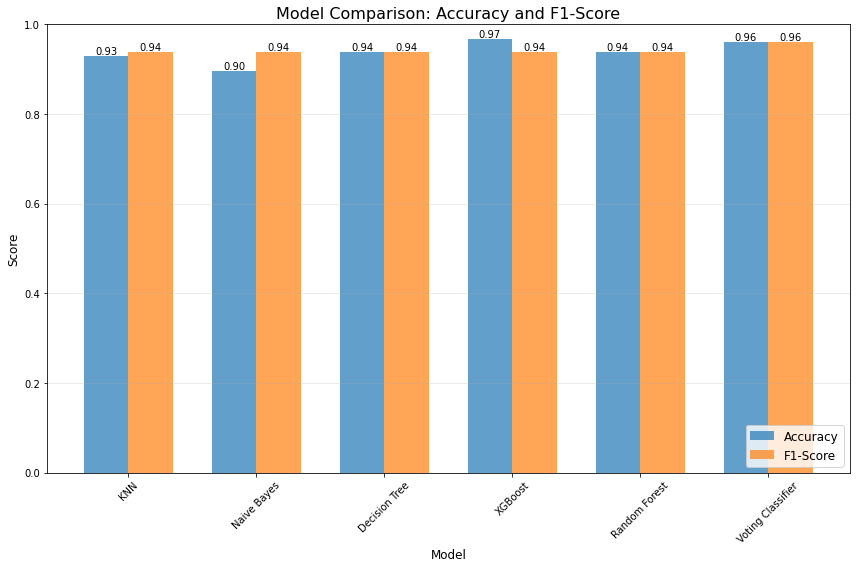

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 6: Extract metrics for plotting
model_names = []
accuracies = []
f1_scores = []

# Loop through results dictionary to extract metrics
for name, result in results.items():
    model_names.append(name)
    accuracies.append(result["Accuracy"])
    report_dict = classification_report(
        y_test,
        model.predict(X_test) if name != "Voting Classifier" else voting_model.predict(X_test),  # Use the correct model for predictions
        output_dict=True,
        target_names=['Low', 'Moderate', 'High']
    )
    f1_scores.append(report_dict["weighted avg"]["f1-score"])

# Convert metrics into a DataFrame
metrics_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "F1-Score": f1_scores
})

# Step 7: Plot Accuracy and F1-Score Comparison
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_df))  # Model indices
width = 0.35  # Width of bars

# Plot bars for Accuracy and F1-Score
bars1 = plt.bar(x - width / 2, metrics_df["Accuracy"], width, label='Accuracy', alpha=0.7)
bars2 = plt.bar(x + width / 2, metrics_df["F1-Score"], width, label='F1-Score', alpha=0.7)

# Add labels and title
plt.title("Model Comparison: Accuracy and F1-Score", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(x, metrics_df["Model"], rotation=45, fontsize=10)
plt.ylim(0, 1.0)  # Both Accuracy and F1-Score are between 0 and 1
plt.legend(loc='lower right', fontsize=12)
plt.grid(axis="y", alpha=0.3)

# Add numbers above each bar
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()


2025-01-11 05:29:12.293350: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-01-11 05:29:12.293391: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-01-11 05:29:12.293397: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-01-11 05:29:12.293414: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-11 05:29:12.293431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a laye

Reloading Tuner from hyperparameter_tuning/deep_learning_classification/tuner0.json
Best Hyperparameters: {'units_input': 64, 'num_hidden_layers': 3, 'units_0': 128, 'dropout_0': 0.5, 'learning_rate': 0.0006398226708967783, 'units_1': 128, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.1}
Epoch 1/30


2025-01-11 05:29:13.687644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


268/268 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step - accuracy: 0.3728 - loss: 2.6872 - val_accuracy: 0.5170 - val_loss: 0.9887
Epoch 2/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4861 - loss: 1.0047 - val_accuracy: 0.6802 - val_loss: 0.7961
Epoch 3/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.6358 - loss: 0.8066 - val_accuracy: 0.6648 - val_loss: 0.6797
Epoch 4/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - accuracy: 0.7090 - loss: 0.6683 - val_accuracy: 0.7646 - val_loss: 0.5703
Epoch 5/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7888 - loss: 0.5107 - val_accuracy: 0.8504 - val_loss: 0.3727
Epoch 6/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8273 - loss: 0.4378 - val_accuracy: 0.9289 - val_loss: 0.2202
Epoch 7/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8959 - loss: 0.3150 - val_accuracy: 0.9138 - val_loss: 0.2806
Epoch 8/30
268/268 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.9191 - loss: 0.2357 - val_accuracy: 0

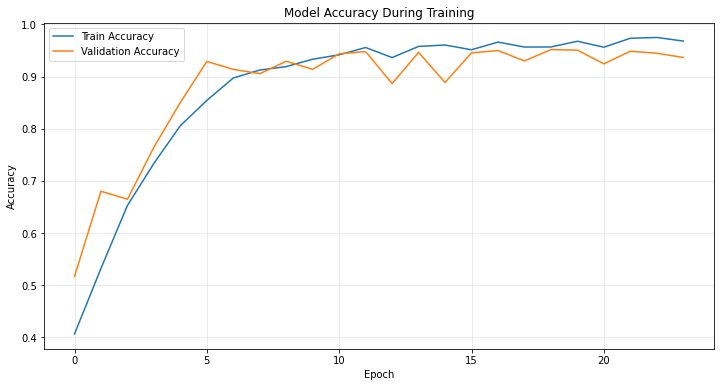

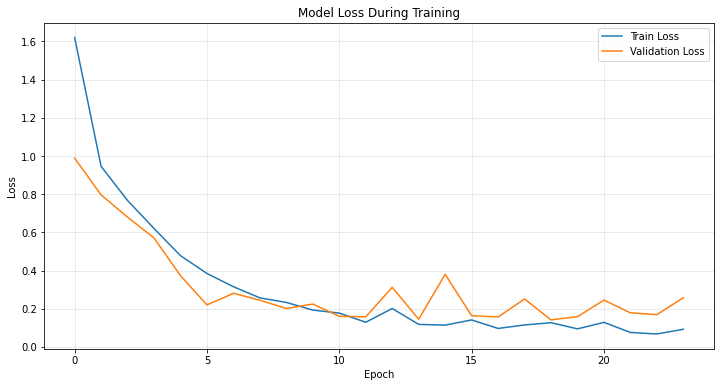

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras_tuner import Hyperband

# Define the model with hyperparameter tuning
def build_model(hp):
    model = Sequential()
    # Input layer
    model.add(Dense(hp.Int('units_input', min_value=32, max_value=128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    
    # Hidden layers with tuning for the number of layers and units
    for i in range(hp.Int('num_hidden_layers', 1, 3)):
        model.add(Dense(hp.Int(f'units_{i}', min_value=32, max_value=128, step=32), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(3, activation='softmax'))  # 3 classes for classification

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

from keras_tuner import RandomSearch

# Initialize Keras Tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,  # Number of hyperparameter combinations to try
    executions_per_trial=1,  # Number of times to evaluate each combination
    directory='hyperparameter_tuning',
    project_name='deep_learning_classification'
)

# Perform hyperparameter tuning
tuner.search(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the model
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=30,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)


# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_dl = best_model.predict(X_test).argmax(axis=1)

# Add results to the dictionary
results["Deep Learning"] = {
    "Accuracy": test_accuracy,
    "Classification Report": classification_report(y_test, y_pred_dl, target_names=['Low', 'Moderate', 'High']),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_dl)
}

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [15]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate the model
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred_dl = best_model.predict(X_test).argmax(axis=1)

# Compute F1-Score
report = classification_report(y_test, y_pred_dl, target_names=['Low', 'Moderate', 'High'], output_dict=True)
f1_score = report['weighted avg']['f1-score']
print(f"F1-Score: {f1_score:.4f}")

# Add results to the dictionary
results["Deep Learning"] = {
    "Accuracy": test_accuracy,
    "F1-Score": f1_score,
    "Classification Report": classification_report(y_test, y_pred_dl, target_names=['Low', 'Moderate', 'High']),
    "Confusion Matrix": confusion_matrix(y_test, y_pred_dl)
}

# Print the classification report
print(f"Classification Report:\n{results['Deep Learning']['Classification Report']}")


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9580 - loss: 0.1260
Test Accuracy: 0.9590
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1-Score: 0.9591
Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.96      0.95       952
    Moderate       0.97      0.97      0.97       952
        High       0.97      0.95      0.96       952

    accuracy                           0.96      2856
   macro avg       0.96      0.96      0.96      2856
weighted avg       0.96      0.96      0.96      2856



90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


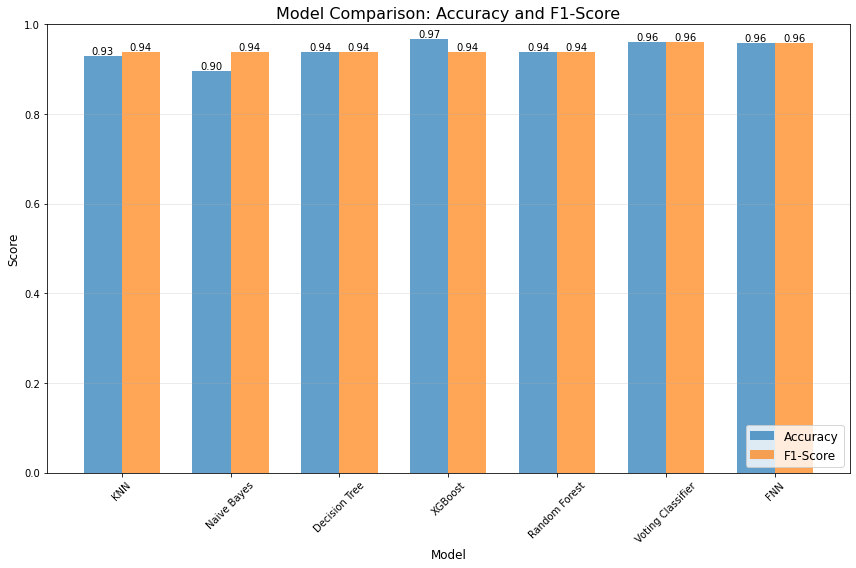

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 6: Extract metrics for plotting
model_names = []
accuracies = []
f1_scores = []

# Loop through results dictionary to extract metrics
for name, result in results.items():
        # Rename "Deep Learning" to "FNN"
    if name == "Deep Learning":
        model_names.append("FNN")
    else:
        model_names.append(name)
    accuracies.append(result["Accuracy"])
    
    # Use correct predictions for each model
    if name == "Deep Learning":
        y_pred = best_model.predict(X_test).argmax(axis=1)  # Predictions for deep learning
    elif name == "Voting Classifier":
        y_pred = voting_model.predict(X_test)  # Predictions for voting classifier
    else:
        y_pred = model.predict(X_test)  # Predictions for other models

    # Compute F1-Score using classification report
    report_dict = classification_report(
        y_test, y_pred, output_dict=True, target_names=['Low', 'Moderate', 'High']
    )
    f1_scores.append(report_dict["weighted avg"]["f1-score"])

# Convert metrics into a DataFrame
metrics_df = pd.DataFrame({
    "Model": model_names,
    "Accuracy": accuracies,
    "F1-Score": f1_scores
})

# Step 7: Plot Accuracy and F1-Score Comparison
plt.figure(figsize=(12, 8))
x = np.arange(len(metrics_df))  # Model indices
width = 0.35  # Width of bars

# Plot bars for Accuracy and F1-Score
bars1 = plt.bar(x - width / 2, metrics_df["Accuracy"], width, label='Accuracy', alpha=0.7)
bars2 = plt.bar(x + width / 2, metrics_df["F1-Score"], width, label='F1-Score', alpha=0.7)

# Add labels and title
plt.title("Model Comparison: Accuracy and F1-Score", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(x, metrics_df["Model"], rotation=45, fontsize=10)
plt.ylim(0, 1.0)  # Both Accuracy and F1-Score are between 0 and 1
plt.legend(loc='lower right', fontsize=12)
plt.grid(axis="y", alpha=0.3)

# Add numbers above each bar
for bar in bars1:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom', fontsize=10)

# Show plot
plt.tight_layout()
plt.show()
